In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
# import numpy as np
import pandas as pd

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os
from degree_days import dds
import autograd.numpy as np




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [4]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values

In [5]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
static_sd = sd_df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [65]:
def cost_feature(H, A, T, H_1, F, E_np_masked, static, case):
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
    HF = np.einsum('na,ab->nb', H_1, F)
    mask_static = ~np.isnan(static)
    error_2 = (HF - static)[mask_static].flatten()
    
    return np.sqrt((error_1**2).mean()) + np.sqrt((error_2**2).mean())

In [88]:
def learn_HAT_adagrad_feature(case, E_np_masked, static, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
                      A_known=None, T_known=None, random_seed=0, eps=1e-8, penalty_coeff=0.0):

    cost = cost_feature
    mg = multigrad(cost, argnums=[0, 1, 2, 3, 4])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)
    H_1 = np.random.rand(params['M'], 2)
    F = np.random.rand(2,3)

    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)
    sum_square_gradients_H_1 = np.zeros_like(H_1)
    sum_square_gradients_F = np.zeros_like(F)

    Hs = [H.copy()]
    As = [A.copy()]
    Ts = [T.copy()]
    H_1s = [H_1.copy()]
    Fs = [F.copy()]
    
    if 'penalty' not in cost_function:
        costs = [cost(H, A, T, H_1, F, E_np_masked, static, case)]
    else:
        costs = [cost(H, A, T, E_np_masked, 2, penalty_coeff)]
    HATs = [multiply_case(H, A, T, 2)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t, del_h_1, del_f = mg(H, A, T, H_1, F, E_np_masked, static, case)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)
        sum_square_gradients_T += eps + np.square(del_t)
        sum_square_gradients_H_1 += eps + np.square(del_h_1)
        sum_square_gradients_F += eps + np.square(del_f)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))
        lr_h_1 = np.divide(lr, np.sqrt(sum_square_gradients_H_1))
        lr_f = np.divide(lr, np.sqrt(sum_square_gradients_F))

        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        H_1 -= lr_h_1 * del_h_1
        F -= lr_f * del_f
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        H = set_known(H, H_1)
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8
        H_1[H_1 < 0] = 1e-8
        F[F < 0] = 1e-8

        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
        H_1s.append(H_1.copy())
        Fs.append(F.copy())
        if 'penalty' not in cost_function:
            costs.append(cost(H, A, T, H_1, F, E_np_masked, static, case))
        else:
            costs.append(cost(H, A, T, F, E_np_masked, static, case))
        HATs.append(multiply_case(H, A, T, 2))
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, H_1, F, E_np_masked, static, sim, case))
    return H, A, T, H_1, F, Hs, As, Ts, H_1s, Fs, HATs, costs




In [79]:
def learn_HAT_feature(case, E_np_masked, static, sim, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None, random_seed=0, decay_mul=1, batchsize=None, aggregate_constraint=False):

    np.random.seed(random_seed)
    lrs = lr*np.power(decay_mul, range(num_iter))
    
    cost = cost_graph_test
    mg = multigrad(cost, argnums=[0, 1, 2, 3, 4])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    
    H = np.abs(np.random.rand(*H_dim))
    A = np.abs(np.random.rand(*A_dim))
    T = np.abs(np.random.rand(*T_dim))
    H_1 = np.abs(np.random.rand(params['M'], 2))
    F = np.abs(np.random.rand(2, 3))

    if batchsize is None:
        batchsize = len(E_np_masked)

    indices_home = range(params['M'])


    # GD procedure
    for i in range(num_iter):
        if batchsize < len(E_np_masked):
            indices_select = np.random.choice(indices_home, batchsize)
            del_h, del_a, del_t, del_h1, del_f = mg(H[indices_select], A, T, H_1, F, E_np_masked[indices_select], static, sim, case)
            H[indices_select] -= lrs[i] * del_h
        else:
            del_h, del_a, del_t, del_h1, del_f = mg(H, A, T, H_1, F, E_np_masked, static, sim, case)
            H -= lrs[i] * del_h
        
        A -= lrs[i] * del_a
        T -= lrs[i] * del_t
        H_1 -= lrs[i] * del_h1
        F -= lrs[i] * del_f
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        H = set_known(H, H_1)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        H_1[H_1 < 0] = 0
        F[F < 0] = 0


        if aggregate_constraint:
            # Projection to ensure A[aggregate] >=sum(A[appliances]
            A[0] = np.maximum(A[0], np.sum(A[1:], axis=0))

        if i % 100 == 0:
            if dis:
                print(cost(H, A, T, H_1, F, E_np_masked, static, sim, case), lrs[i], i)
    return H, A, T, F

In [91]:
n_splits = 10
case = 2
a = 5
b = 3
c = 1
cost = 'abs'
iters = 2000

# H_au, A_au, T_au, F_au = learn_HAT_graph(2, au_tensor, static_au, sim_au, a, b, num_iter=iters, dis=True, T_known = np.ones(12).reshape(-1, 1))
H_au, A_au, T_au, H_1, F, Hs, As, Ts, H_1s, Fs, HATs, costs = learn_HAT_adagrad_feature(2, au_tensor, static_au, sim_au, a, b, num_iter=iters, dis=True, T_known = np.ones(12).reshape(-1, 1))
pred_normal = {}
pred_transfer = {}
for random_seed in range(10):
    pred_normal[random_seed] = {}
    pred_transfer[random_seed] = {}
    
    for appliance in APPLIANCES_ORDER:
        pred_normal[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    np.random.seed(random_seed)
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
           
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            
            ############################################################################################
            # Normal learning: no constant constraint, no A_known, with learn_HAT
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, T_known = np.ones(12).reshape(-1, 1))
            H, A, T, H_1, F, Hs, As, Ts, H_1s, Fs, HATs, costs = learn_HAT_adagrad_feature(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, T_known = np.ones(12).reshape(-1, 1))


            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_normal[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
                       
            
            ############################################################################################
            # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, A_known = A_au, T_known = np.ones(12).reshape(-1, 1))
            H, A, T, H_1, F, Hs, As, Ts, H_1s, Fs, HATs, costs = learn_HAT_adagrad_feature(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, A_known = A_au, T_known = np.ones(12).reshape(-1, 1))


            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_transfer[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            rd += 1

498.425436733
134.702536671
98.1946352918
90.2531433831
random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
384.857683348
70.5025572465
63.5010456134
59.4141729836
372.663270163
66.3310220144
62.0920267634
60.9250481163
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
294.402424808
41.3655379513
39.9548233117
39.6913430144
281.605176325
46.4060908771
42.6932405983
41.1305868752
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
241.180037837
30.0751858415
29.9341452744
29.6034860896
223.098448831
31.7466914597
30.5309779486
30.1533676389
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
268.375287274
31.9263944345
30.2128279627
29.7348241853
250.724091085
33.6156687119
31.5811771562
31.2187034822
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
292.683494479
30.8926753909
23.6725692103
23.2184544791
278.739521365
28.9830631922
25.1099793746
2

34.6117508999
34.1733684908
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
222.842375293
38.2237815603
34.1597959533
33.2042074197
209.57763264
36.8855993639
34.3667469911
33.7456440055
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
222.971035098
44.3509893788
40.092195646
38.6432366853
212.86886391
41.9491452747
39.876567344
39.4681796437
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
234.024367175
36.265840065
35.0053582606
34.1034956053
223.130428546
35.8343027791
34.1669268122
33.7372562699
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
260.163658332
43.914627088
37.8720016343
36.8193832754
250.237250994
41.7552759076
38.1031623892
37.2353469643
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
255.020046598
42.8635547022
35.1031012213
33.3309981864
241.591859531
38.5128493422
34.8817498859
34.0588236612
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='

39.1115778097
33.371606063
31.9732058239
205.059273162
35.679563244
33.4961802099
32.9410593031
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
224.219071875
40.15825612
35.0886845887
34.124976058
212.252782298
38.1369690615
35.5372569441
35.0473614982
training percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
220.844483189
40.6689704968
35.3513855491
33.8875120402
208.864155094
37.2377520613
35.1265497262
34.6754327199
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
221.275759856
41.1496641296
35.4569215312
34.0028223493
207.797775907
37.8144395381
35.4577868305
34.8704549666
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
227.388040192
40.7256712435
36.1092307675
34.7633707582
213.363716938
39.2595968547
36.3355550658
35.5936345634
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
221.505032398
43.3627729578
40.5495611987
36.5245943657
209.302392497
38.655851295


41.4642458201
38.3182324052
37.4010682258
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
216.833724762
36.7387058988
32.1812411502
30.5809214837
203.785023091
35.4684632289
31.5608811768
30.614713765
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
216.141543071
43.9711748176
36.3560724093
33.6958323191
204.44931479
40.7756975412
37.7428968122
36.6127733524
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
235.830717192
37.738311554
33.0353438926
31.9006258119
223.988595405
35.6148607109
32.9760578491
32.4070157626
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
216.73816625
31.4518159219
26.3324723345
25.7959008815
200.989964161
28.5270974524
26.6379760004
26.3158344656
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
229.710748373
41.898823997
38.0565764319
37.1338435885
219.066660523
40.1327388227
38.358197075
37.9998527626
round:  8
test_ix:  Int64Index([8733, 9213, 

41.0407231751
35.2880767846
33.8179522574
216.60480754
39.0519597797
35.9310789238
35.2103917737
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
235.358992511
40.5324643799
34.6339235245
33.3115954808
222.704512776
37.6372355637
35.0094534398
34.3274310242
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
223.867345754
44.8368835292
41.6963977699
35.7589777197
213.525833664
38.7130231192
36.3619061153
35.772784581
training percentage:  90
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
226.774828394
39.4086994133
34.9435561002
33.9077430178
214.173754759
38.0772318206
35.7331921246
35.0958899009
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
213.728310318
40.3936078483
38.2476890409
36.6853853094
203.23384525
37.4182822951
35.1380045136
34.5893173798
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
229.625170698
44.2098246936
37.2187605181
35.2558514447
218.872828449
39.750567982

229.504586453
36.0536575327
34.5128422657
34.026431431
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
214.004530625
35.7397973178
33.9730375346
31.3201409739
199.89253175
35.0901023539
32.7308356986
31.8192928556
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
233.918693602
34.2555863394
29.1949100873
28.2653553734
224.447798173
32.2034065473
29.6933453564
29.283937113
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
177.929322254
33.9629926107
29.2979756876
27.5861385521
166.095352759
33.0873071968
30.9515480328
30.1273178528
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
233.848877789
43.1566401568
37.936963655
36.151522207
222.037987599
40.4950007533
38.5076862437
37.983771562
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
259.122197412
38.1310019841
34.6089644057
33.8600998836
244.607634939
36.3082704276
34.7623392217
34.410859631
round:  7
test_ix:  Int64Index(

37.7985758312
35.0833748942
33.9250666087
210.196130829
37.3014633416
35.5536510677
35.1974173063
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
245.438273855
44.1725042797
39.5665336421
37.476102225
231.984680294
41.7133633148
38.7639571705
38.0100974361
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
235.860306026
42.6966074742
37.7177697024
35.9185224576
225.638347135
39.7432251803
37.2766721395
36.753222506
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
211.077332149
33.8628975374
29.7264565036
28.7079139391
197.497430872
32.7213934129
30.301203655
29.6648973577
training percentage:  80
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
231.384449871
41.9847699562
36.4480708083
34.7278493243
219.369927715
39.2287390409
36.4766661571
35.8865555492
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
235.47248434
41.2699488122
36.716438453
35.2968202841
223.666075971
38.9300811296


44.3701492605
40.8411931819
39.8545967023
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
259.871850014
42.9834881677
42.053065588
40.9443242974
243.267756149
41.1749067799
39.9815538709
39.6643619
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
205.64563309
30.9095804732
27.6734411779
25.9855119334
189.951276247
29.1736052661
27.5560643445
27.1976765594
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
316.948312838
42.4717287744
38.6603631688
37.7677550485
303.622615486
41.9928837338
39.2169466307
38.5400608532
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
208.191182436
28.9609147195
24.9723914505
23.6016954606
199.11404659
28.5268875587
25.6138342247
24.7999921418
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
241.188414995
35.6235215816
30.4091903052
28.6458267566
225.797227039
32.6762445054
30.4806316272
29.9606760989
round:  6
test_ix:  Int64Index([6547, 7062, 

35.278950021
31.6387070396
30.3282673968
201.468215784
33.9121371445
32.1284947578
31.8522350284
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
230.648897586
39.7240324233
34.5131715701
32.7992612087
218.651657231
35.1869148775
33.5343827829
33.2502641919
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
200.675145236
37.2258510927
33.2910451635
32.3047891958
186.313974538
35.6996950159
33.5233873114
32.9733705872
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
223.557347777
37.0525306221
31.6531764904
30.3679560924
210.129739605
35.5012701884
32.4277409189
31.58807343
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
221.743009305
41.4085827834
37.9062203835
36.7703822472
209.225632223
39.6719949658
37.6072513159
37.1835854726
training percentage:  70
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
235.702361867
43.224230499
40.1171361529
39.8047908515
223.972566172
39.4038004713

random seed:  4
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
346.478284811
52.8632593843
49.2621504255
48.5040536172
330.550775736
51.3869362769
49.1676310197
48.7095648989
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
266.625707617
37.7907087078
37.4588766316
37.0532110124
250.556661263
37.904162496
37.4668970545
37.295984154
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
292.021955746
43.0074968955
39.5266499762
36.3167488063
274.924782912
42.5185661032
37.7752037582
36.652212272
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
236.032993387
28.9546282357
23.266924699
20.5613176451
224.612104084
28.5116427819
25.3688229712
24.9244336186
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
226.230256303
38.4176903379
37.0683742601
36.2623376818
212.528522987
38.4046021177
37.3839982893
37.2110656506
round:  5
test_ix:  Int64Index([6268, 6377, 642

31.5389381829
26.9587408064
23.9117657698
196.424408544
32.544922402
28.8115086975
28.0411002481
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
244.770645539
42.7851635465
38.9566259978
37.7591633282
232.314847599
42.8163319761
40.0592672333
39.5114506895
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
230.932399674
42.3509957341
38.3260086292
36.9092437588
217.561986605
40.891252583
38.8336089523
38.3770328861
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
217.729182946
44.2483048321
42.7109448135
42.3549390519
206.184711159
42.604202973
39.4340164957
38.5852789561
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
230.527828518
42.5994097027
35.5887286631
34.0403359694
217.143188689
37.9766549887
35.8994500098
35.4582848842
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
223.983406093
39.5176727931
35.6565860782
34.936284414
213.039873675
38.2409300414
36.1899926248
35.815

33.8399209884
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
236.110892547
41.522199623
36.6104817087
35.3177949242
224.496899961
38.7188662369
36.3345529672
35.7970761087
training percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
220.66783897
39.9727703827
34.8684935042
33.4476429189
209.295174888
37.6353199854
35.4529872638
34.9460573027
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
220.987709347
39.8589900054
35.4436131898
34.0039390289
210.500418694
38.1175694598
35.6170141672
35.0609666434
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
227.152012816
42.4101748725
35.8442934908
34.3106720261
213.832755068
38.7755746069
36.2047603961
35.5946701152
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
220.538495535
39.7073133326
34.4444630891
33.1389437957
211.602028009
38.2842631408
35.5729019613
34.9914295353
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 59

39.0440289325
35.5994053053
33.6524410811
208.258253032
39.1513677621
36.8595692537
36.3682660074
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
242.384598335
41.759263694
36.155477746
34.6764724387
231.097984272
40.2295243286
36.8678394228
35.886936577
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
234.840531919
44.5143156624
37.5109411798
35.6605936101
224.061931644
40.1481881529
37.6140196887
37.1473827069
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
265.647333879
45.851492881
39.0183872155
37.8403676084
251.150821672
40.8686350615
38.7451955432
38.2734671405
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
214.77494011
40.6914377869
35.8348533398
34.5529992763
202.605558396
38.9285757182
36.0922196614
35.347444988
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
260.057245755
45.248039247
39.3245706502
37.6195758012
247.002263988
43.1252429614
39.70341062
38.69

round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
228.366002215
39.7802828798
35.9775372039
32.4397522782
215.664017066
35.8483183055
33.0124090888
32.4917719322
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
234.044105869
38.4082830527
35.1569155591
34.4688089163
221.116184204
37.8213968671
35.5644386426
35.1562917777
training percentage:  90
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
223.403953519
41.6657471522
35.9464677898
34.3451151252
211.623225109
38.557497432
36.0132520959
35.5428059764
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
223.986742732
38.518981338
34.7878951586
33.5777845912
209.015099361
37.4553248538
35.3486713271
34.8706947597
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
239.115922421
42.5204913041
37.1479313319
35.9673058483
228.218996254
40.5597360972
37.7265792621
37.0691108203
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int

40.021632813
37.2480975003
34.0549065016
208.316672896
35.5322880362
34.4361273365
34.2091758969
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
259.812613904
44.7353575562
41.5085697824
37.0397668478
247.172098288
42.0660204648
39.3061989182
38.5579158659
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
255.992299766
48.684660989
42.6149325614
41.1964121135
243.670736661
43.8925130433
41.6889831332
41.362294775
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
247.991844768
39.8855444697
36.0843657819
35.250237366
235.776548165
37.8034781718
36.0782808749
35.8369522671
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
290.47800549
39.4196517455
36.7960047404
36.1408304351
276.65862661
39.7780072098
37.271343645
36.8005703501
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
245.02661002
43.1741938315
39.6821892221
37.9702000301
235.346637512
43.843675495
40.6458771293
39.96

round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
259.837576904
47.1761109482
39.504133862
38.4556338592
246.279172998
41.889464398
39.5541845377
39.0616562883
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
234.030796689
40.9241290872
37.8737740223
36.7671902572
221.7354134
39.5513468564
37.6123589603
37.2057967359
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
219.715080435
38.2694738414
34.6993201627
33.182808105
206.543103477
38.079270679
35.4382805694
34.6712419917
training percentage:  80
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
221.731569388
40.8232329717
35.4924330726
33.5419833182
209.845345894
37.2880557292
34.5786224206
33.8880409922
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
215.66147203
40.2910206562
38.4237513255
37.2702426913
201.849958804
37.8999623598
35.6161862156
35.0966572166
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')


39.2023455103
38.8269807355
38.4098685309
242.23421269
40.4412201676
38.9795216422
38.6826012339
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
278.812531239
36.4983534522
35.7192903074
35.1063211018
262.967873947
37.8133380107
35.6741515341
35.119235465
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
199.513219454
32.1661437837
28.9994184724
26.507884605
185.681334465
31.7103040453
27.9536656518
26.9011846895
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
217.562319321
40.6324131653
34.3490071012
32.6291834213
201.074681844
38.9152211341
35.2796621034
34.3122994794
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
208.788822131
33.4851373238
30.8288579469
29.949540223
197.381407081
34.2708978449
32.2255198774
31.8559878698
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
196.170527774
29.6603541479
28.2915395524
25.6207482142
184.73994178
28.9973249984
26.4604111921
2

round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
243.434696204
40.8744435315
35.6740488606
34.1118803578
232.362949067
39.1024420263
36.2278421495
35.6108621234
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
250.314066608
40.6151430718
37.2517201994
36.6749532747
239.380947903
39.5865144444
37.4144211482
36.9679398675
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
236.03826473
43.8641609003
38.9786434809
37.6561585969
223.48381639
41.6959802553
39.209451907
38.706218074
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
234.650767299
42.7236628397
36.2105595688
34.540836418
222.56335174
41.3381581012
37.4677153174
36.6347931542
training percentage:  70
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
247.828464507
44.4244073724
38.6378883608
37.0554507842
234.694578234
42.6872908677
39.3907830218
38.5112094198
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')

44.849711099
40.6241617323
39.5136691421
327.208591057
43.1656753694
40.8140913715
40.4511343137
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
295.381056418
39.4960794545
39.1861074617
39.0124983435
282.453771092
39.8114020429
39.5155072156
39.3825515866
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
383.369032854
47.4261036103
44.3656481602
43.1867706023
365.829194736
46.6196196554
43.5319807503
42.5463665654
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
259.37242691
22.8968249057
21.7849666235
21.211283561
246.379514524
30.4795351846
23.6649173747
21.4308009575
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
253.646233386
33.6595357602
30.8310141379
30.1278035959
245.627125357
34.5076461525
31.8980162101
31.5144732095
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
243.502920254
16.755137463
16.5025703626
16.4292690903
224.652963449
28.0183020757
20.1886820921


34.7286908386
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
265.063121761
43.3820185402
40.0603013757
39.0851225838
253.663002694
43.5193207246
40.4468638996
39.8477059881
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
206.222290203
40.195098008
34.9306670933
33.2611836925
193.56714008
37.9542705909
35.6943258933
35.2442142981
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
213.373859128
43.529900671
38.1720030351
35.8493988571
198.948418678
39.7536101154
37.1094293706
36.4970263456
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
240.582259
42.9582307159
36.2273624089
34.7819027301
226.406263333
39.5398729828
36.8224892821
36.1209883859
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
221.701685647
41.0078967259
37.868538094
36.293148359
209.105246056
40.4088585416
38.6333063107
38.2705548468
training percentage:  60
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dt

40.0564667226
34.4040594406
33.3056181902
201.669367175
37.5147744673
34.5640624246
33.9970702526
training percentage:  100
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
220.518090509
41.4932982382
35.5011054205
33.91215105
208.481233594
37.6643100707
35.3304206612
34.7939682071
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
220.697062658
40.7031367264
36.0872866477
34.4900668267
210.056202241
37.750839087
35.2909524741
34.8135946708
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
227.030818904
41.550598166
36.0540274386
34.7611674815
216.351471476
39.1955401978
36.1830332823
35.6106775648
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
220.838078978
40.9038120694
35.5751458858
34.0983093731
209.557501781
38.630539029
35.698092807
35.0100983429
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
223.353577026
41.7149857598
35.8227790814
34.218477251
212.127566586
38.793619

36.4907388265
33.2827012631
32.2104306228
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
213.814561683
40.4884373424
36.1413662911
33.7705862054
200.201702399
37.6667863572
34.8203852943
34.148811044
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
213.540592779
32.7967338029
29.8184118929
29.2959048037
202.799051502
33.9391284785
30.5039202131
29.532753076
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
200.98194397
34.2539280252
31.0361305709
29.6115732475
192.601111503
33.6491116215
32.0682988383
31.6325531786
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
235.367926214
44.6540964155
40.607673584
38.2466500342
222.940625053
42.432509493
39.5729687774
38.7939245137
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
263.109684953
45.0688842629
38.2655520504
36.9204831984
250.68015871
41.6963286438
38.3990954041
37.7521169491
round:  9
test_ix:  Int64Index([9612, 9775, 

43.3550375213
37.0143229236
35.0957327302
219.394305279
40.0277507457
37.1324059419
36.4476855091
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
217.106088632
39.1495427558
34.8995355708
33.6079062535
205.747569907
37.5737162241
35.1611306779
34.588134843
training percentage:  90
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
223.568854659
40.3430913591
35.2933017536
34.0327033898
210.832462933
37.9993165984
35.4702832069
34.7873084345
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
214.056270173
40.6098620036
35.6470324548
34.0797393359
201.00539571
37.7638570709
35.4352421093
34.8578171597
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
234.679453492
44.3413681665
37.8748821764
36.4294644089
223.506452338
40.1085556403
37.4790572327
36.8632932256
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
217.940358634
40.346663941
33.1950236677
32.16054736
207.332683997
36.2532079181


In [92]:
out = {}

out_normal = {}
out_transfer = {}

for random_seed in range(10):
    out_normal[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_normal[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_normal[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
for random_seed in range(10):
    out_transfer[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [93]:
mean_out_normal = pd.Panel(out_normal).mean(axis=0)
mean_out_transfer = pd.Panel(out_transfer).mean(axis=0)

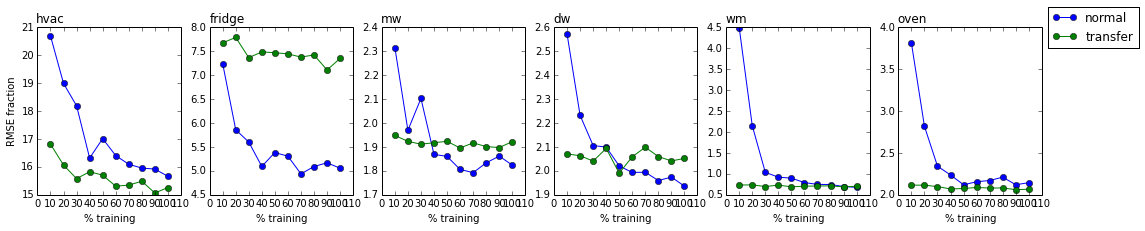

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0
algo = 'adagrad'

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = mean_out_normal[appliance]
    df2 = mean_out_transfer[appliance]
   
    df = pd.concat([df1, df2], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')
# plt.suptitle(algo, fontsize=17,y=1.04)


ax[count-1].legend(['normal', 'transfer'], loc='center left' , bbox_to_anchor=(1, 1))
plt.savefig("./analysis/0720/normal_transfer_graph_adagrad.pdf", bbox_inches="tight", dpi=300, format='pdf')

In [30]:
H, A_sd, T, F = learn_HAT_graph(2, sd_tensor, static_sd, sim_sd, 2, 3, dis=True, A_known = A, T_known = np.ones(12).reshape(-1, 1))

0
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  0.50155743,  0.9567711 ],
       [ 1.        ,  0.42404395,  0.6

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  2.31187001,  1.96716822],
       [ 1.        ,  2.16853152,  1.389

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  3.01376631,  1.08888049],
       [ 1.        ,  2.97478638,  0.497

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  3.55688963,  0.4391647 ],
       [ 1.        ,  3.40837305,  0.032

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  3.89527831,  0.07904637],
       [ 1.        ,  3.4839988 ,  0.   

       [ 0.        ,  0.02421702,  0.02064215]]))
196
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.03798899, 

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.06767623,  0.        ],
       [ 1.        ,  3.52258113,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.08000238,  0.        ],
       [ 1.        ,  3.53313939,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.0996499 ,  0.        ],
       [ 1.        ,  3.55005817,  0.   

346
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.12412738,  0.        ],
       [ 1.        ,  3.57122619,  0

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.13864631,  0.        ],
       [ 1.        ,  3.58380721,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.15468455,  0.        ],
       [ 1.        ,  3.59772893,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.16727616,  0.        ],
       [ 1.        ,  3.60867405,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.18074503,  0.        ],
       [ 1.        ,  3.62037345,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.19538366,  0.        ],
       [ 1.        ,  3.63310803,  0.   

       [ 0.        ,  0.02493969,  0.0243909 ]]))
516
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.2094871 , 

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.22464182,  0.        ],
       [ 1.        ,  3.65855705,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.23825142,  0.        ],
       [ 1.        ,  3.67039088,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.25145899,  0.        ],
       [ 1.        ,  3.68188324,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.26571926,  0.        ],
       [ 1.        ,  3.69429278,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.28059603,  0.        ],
       [ 1.        ,  3.70724711,  0.   

682
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.29390005,  0.        ],
       [ 1.        ,  3.71882632,  0

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.30767063,  0.        ],
       [ 1.        ,  3.73080494,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.32365905,  0.        ],
       [ 1.        ,  3.74472945,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.33747059,  0.        ],
       [ 1.        ,  3.75674487,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.3518797 ,  0.        ],
       [ 1.        ,  3.76928845,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.36629665,  0.        ],
       [ 1.        ,  3.7818394 ,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.38336219,  0.        ],
       [ 1.        ,  3.79670453,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.39880691,  0.        ],
       [ 1.        ,  3.81015153,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.41262553,  0.        ],
       [ 1.        ,  3.82217538,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.42554621,  0.        ],
       [ 1.        ,  3.83343354,  0.   

970
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.44196804,  0.        ],
       [ 1.        ,  3.84773293,  0

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.45733137,  0.        ],
       [ 1.        ,  3.8611112 ,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.47207338,  0.        ],
       [ 1.        ,  3.87394078,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.48531991,  0.        ],
       [ 1.        ,  3.88547659,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.4991087 ,  0.        ],
       [ 1.        ,  3.89749338,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.51429374,  0.        ],
       [ 1.        ,  3.91071843,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.52883785,  0.        ],
       [ 1.        ,  3.92337734,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.54088585,  0.        ],
       [ 1.        ,  3.93387102,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.55488041,  0.        ],
       [ 1.        ,  3.94606056,  0.   

       [ 0.        ,  0.02702803,  0.03262666]]))
1224
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.57036604,

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.58265101,  0.        ],
       [ 1.        ,  3.97025074,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.59739703,  0.        ],
       [ 1.        ,  3.98309636,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.61552248,  0.        ],
       [ 1.        ,  3.99889557,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.63389214,  0.        ],
       [ 1.        ,  4.01489956,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.65438284,  0.        ],
       [ 1.        ,  4.03274332,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.67517204,  0.        ],
       [ 1.        ,  4.05085734,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.68079489,  0.        ],
       [ 1.        ,  4.05575683,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.69992652,  0.        ],
       [ 1.        ,  4.0724373 ,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.71682725,  0.        ],
       [ 1.        ,  4.08715586,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.73494291,  0.        ],
       [ 1.        ,  4.10294345,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.74264364,  0.        ],
       [ 1.        ,  4.10966446,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.75155026,  0.        ],
       [ 1.        ,  4.11742708,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.75987082,  0.        ],
       [ 1.        ,  4.1246694 ,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.76777279,  0.        ],
       [ 1.        ,  4.13155678,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.77995548,  0.        ],
       [ 1.        ,  4.1421756 ,  0.   

       [ 0.        ,  0.02823029,  0.03669566]]))
1688
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.7865068 ,

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.79542044,  0.        ],
       [ 1.        ,  4.15565601,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.80729194,  0.        ],
       [ 1.        ,  4.16600463,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.81485029,  0.        ],
       [ 1.        ,  4.17259362,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.82318056,  0.        ],
       [ 1.        ,  4.17985575,  0.   

       [ 0.17200067,  0.02849755,  0.03753251]]))
1799
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.83308186,

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.83848328,  0.        ],
       [ 1.        ,  4.19320709,  0.   

1830
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.84579841,  0.        ],
       [ 1.        ,  4.19958487,  

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.85577774,  0.        ],
       [ 1.        ,  4.20827549,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.86453673,  0.        ],
       [ 1.        ,  4.21591262,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.8721123 ,  0.        ],
       [ 1.        ,  4.22252849,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.88023329,  0.        ],
       [ 1.        ,  4.22959945,  0.   

       [ 0.        ,  0.0287951 ,  0.03846338]]))
1942
(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.88997647,

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.89639548,  0.        ],
       [ 1.        ,  4.24369326,  0.   

(array([[[  8.62453811e+00,   3.05422133e+01,   1.42682646e+01],
        [  6.78740460e+00,   7.00826013e+00,   2.63254600e+01]],

       [[  0.00000000e+00,   0.00000000e+00,   9.99129140e-01],
        [  0.00000000e+00,   0.00000000e+00,   1.93591743e+01]],

       [[  1.19093328e+00,   7.68700265e-01,   4.12197942e-01],
        [  1.42431458e+00,   1.71265880e+00,   1.10106623e+00]],

       [[  8.26006841e-01,   2.00293372e-01,   5.93213074e-02],
        [  6.14021498e-01,   4.58198468e-02,   7.75830033e-03]],

       [[  4.17105894e-01,   2.90825442e-01,   8.22848585e-02],
        [  9.30167953e-01,   1.83349963e-01,   6.73544096e-02]],

       [[  4.30496569e-03,   1.16751580e-01,   3.91494626e-02],
        [  4.78025863e-01,   4.48148194e-02,   2.83147120e-02]],

       [[  2.41032305e-01,   2.92259787e-01,   3.95217629e-02],
        [  7.94547572e-01,   4.10919888e-01,   1.16438596e-01]]]), array([[ 1.        ,  4.90519117,  0.        ],
       [ 1.        ,  4.25137428,  0.   

In [33]:
HAT = multiply_case(H, A_sd, T, 2)
pred = {}

for appliance_name, appliance_id in appliance_index.iteritems():
    pred[appliance_name] = []
    pred[appliance_name].append(pd.DataFrame(HAT[:,appliance_id,:], index=sd_df.index))

In [36]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse
from common import compute_rmse_fraction
out = {}
for appliance in APPLIANCES_ORDER[1:]:
    out[appliance] = {}
    s = pd.concat(pred[appliance]).ix[sd_df.index]
    if appliance=="hvac":
        out[appliance] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
    else:   
        out[appliance] = compute_rmse_fraction(appliance, s,'SanDiego')[2]



In [37]:
H_au, A_au, T_au, F_au = learn_HAT_graph(2, au_tensor, static_au, sim_au, 2, 3, dis=True, T_known = np.ones(12).reshape(-1, 1))

{'dw': 1.8367728773374887,
 'fridge': 9.8657088545261136,
 'hvac': 11.60165725904209,
 'mw': 2.0589824413134963,
 'oven': 2.0293130291040335,
 'wm': 0.813957131729387}